# P53 - DMS Analyse
#### by Frido Petersen, Dario Prifti, Maximilian Fidlin and Enno Schäfer
*With special thanks to our Co-Worker, inspiration and beloved friend: Chat-GPT*

In [10]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import seaborn as sns
import data_exploration as de
import data_cleanup as dc
import functions as fun
import Documentation as doc
import severity_score as ses

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
# These are all the datasets we used
gia_null_eto: pd.DataFrame = pd.read_csv('../DMS_data/P53_HUMAN_Giacomelli_NULL_Etoposide_2018.csv')
gia_null_nut: pd.DataFrame = pd.read_csv('../DMS_data/P53_HUMAN_Giacomelli_NULL_Nutlin_2018.csv')
gia_wt_nut: pd.DataFrame = pd.read_csv('../DMS_data/P53_HUMAN_Giacomelli_WT_Nutlin_2018.csv')
kot_hum: pd.DataFrame = pd.read_csv('../DMS_data/P53_HUMAN_Kotler_2018.csv')

aa = pd.read_csv('../DMS_data/aminoacids.csv')

## Comparibility of p53 Datasets
#### Finding similarities and differences in the 4 datasets on p53

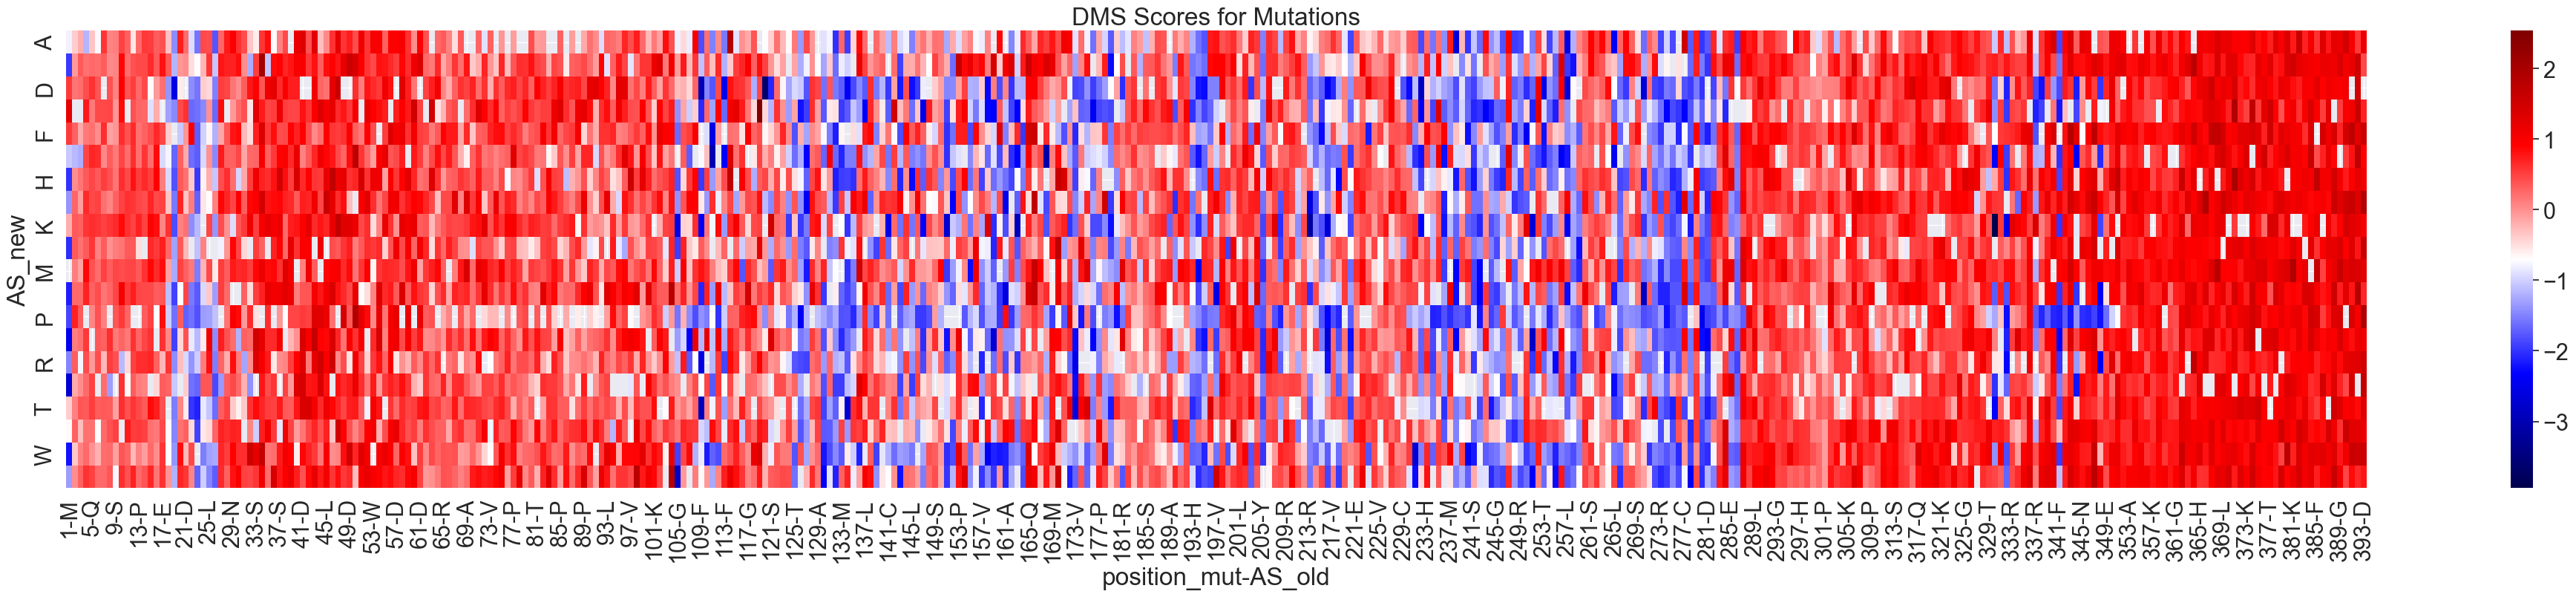

In [12]:
# giacomelli null etoposide
fun.hmap(doc.gia_null_eto_auf)

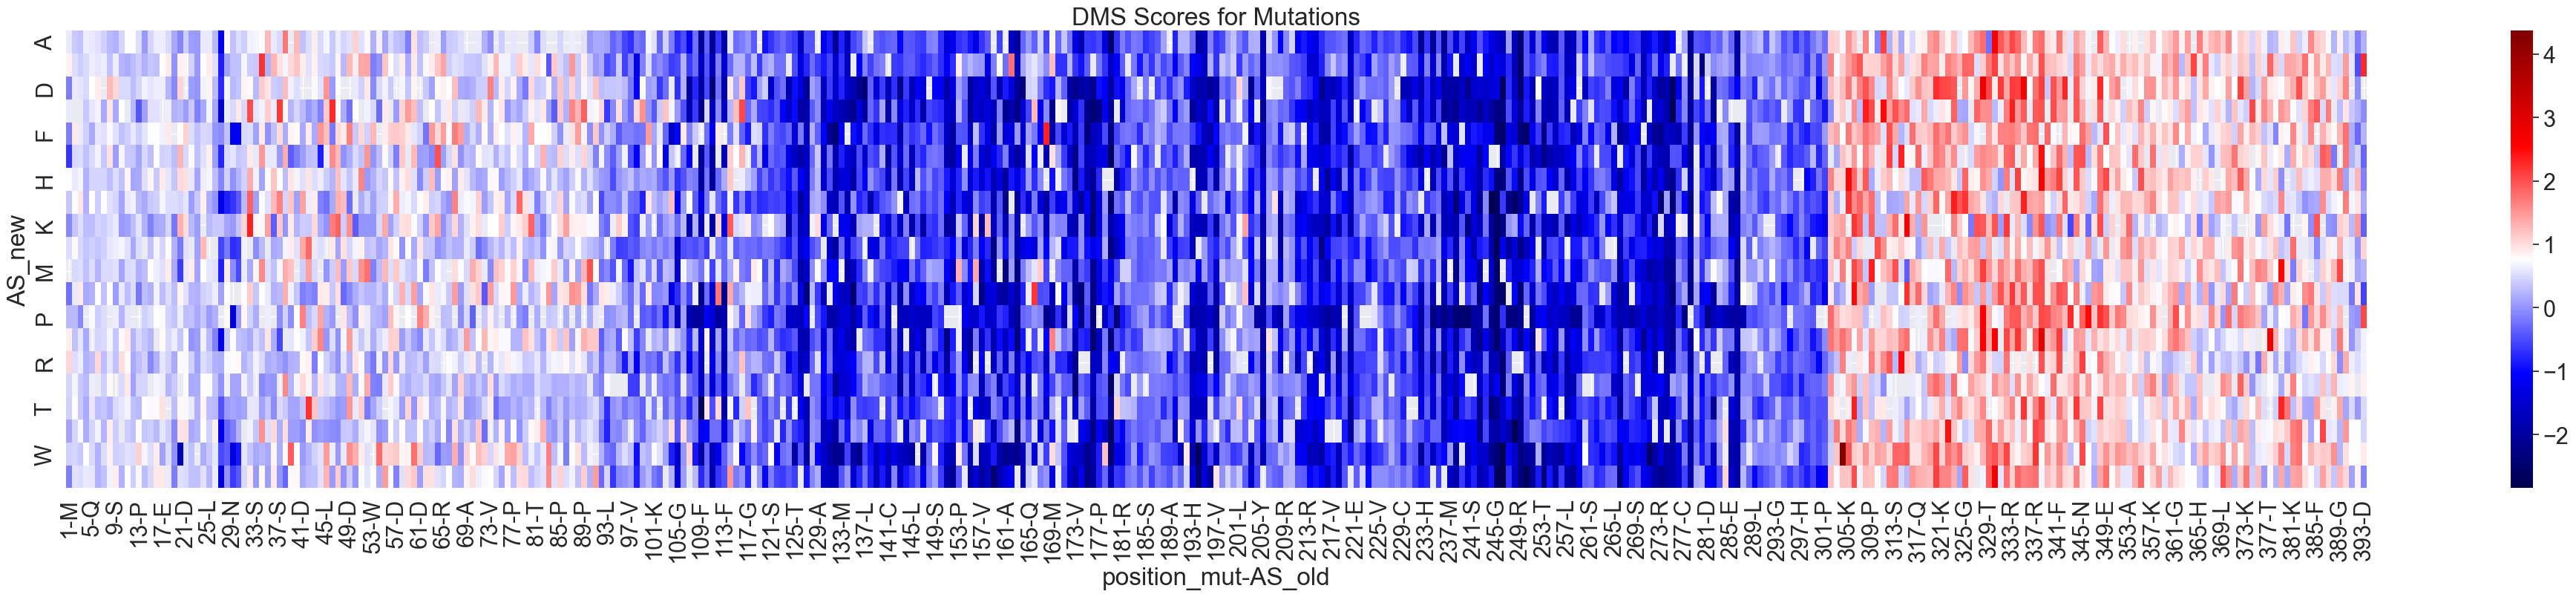

In [13]:
# giacomelli wildtype nutlin
fun.hmap(doc.gia_wt_nut_auf)

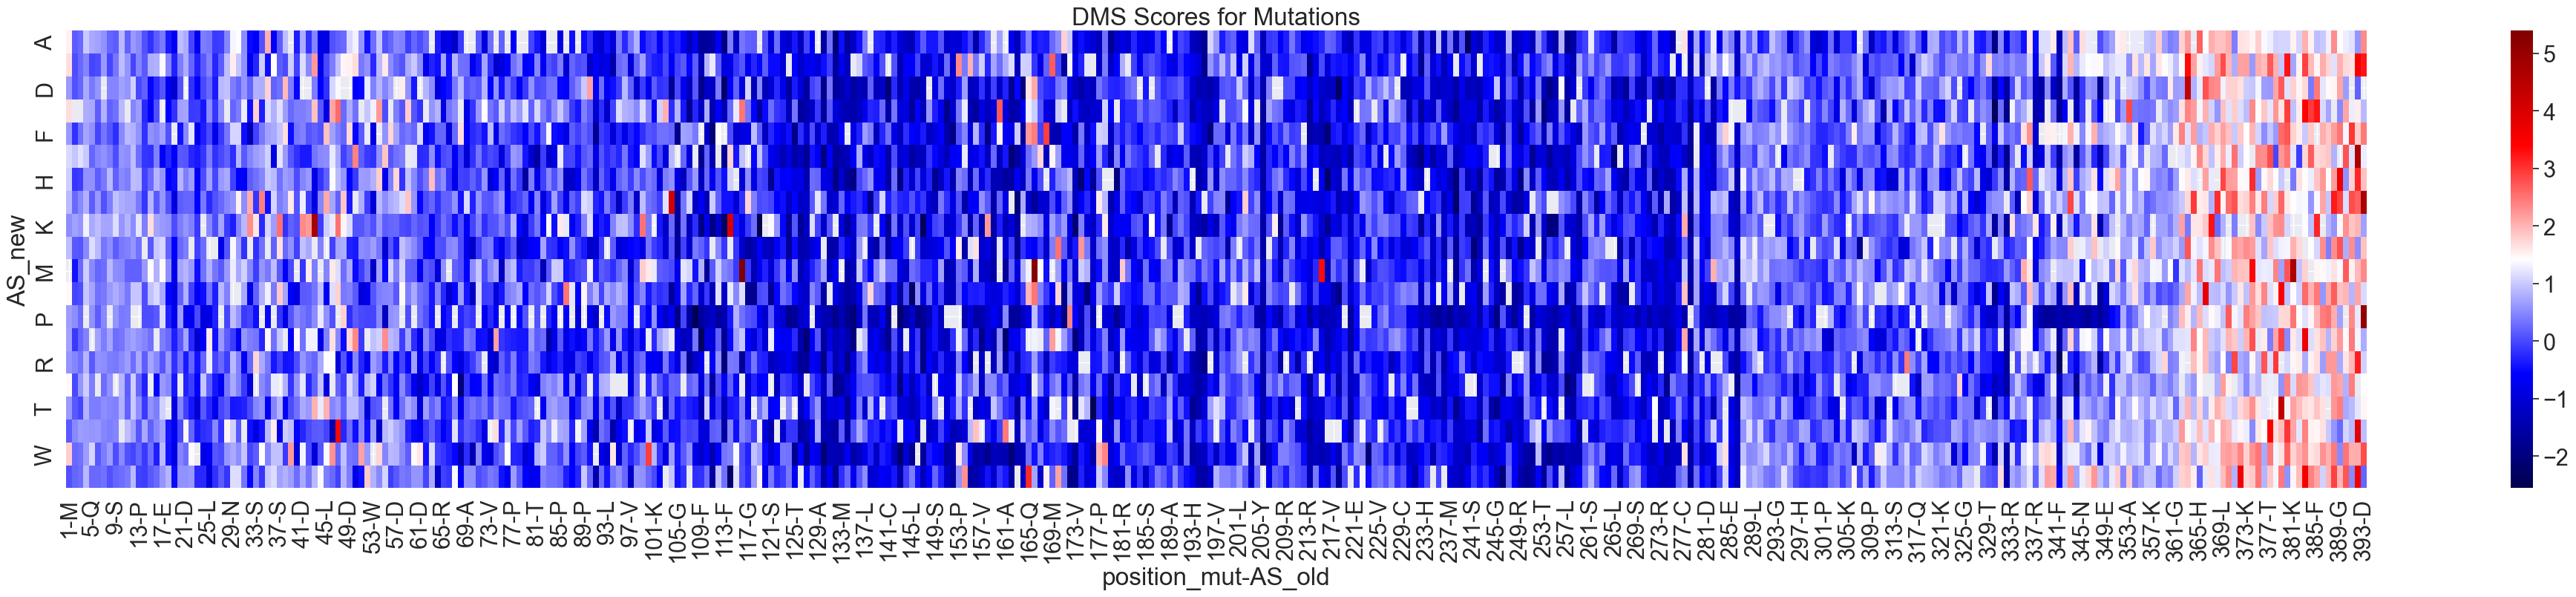

In [14]:
# giacomelli null nutlin
fun.hmap(doc.gia_null_nut_auf)

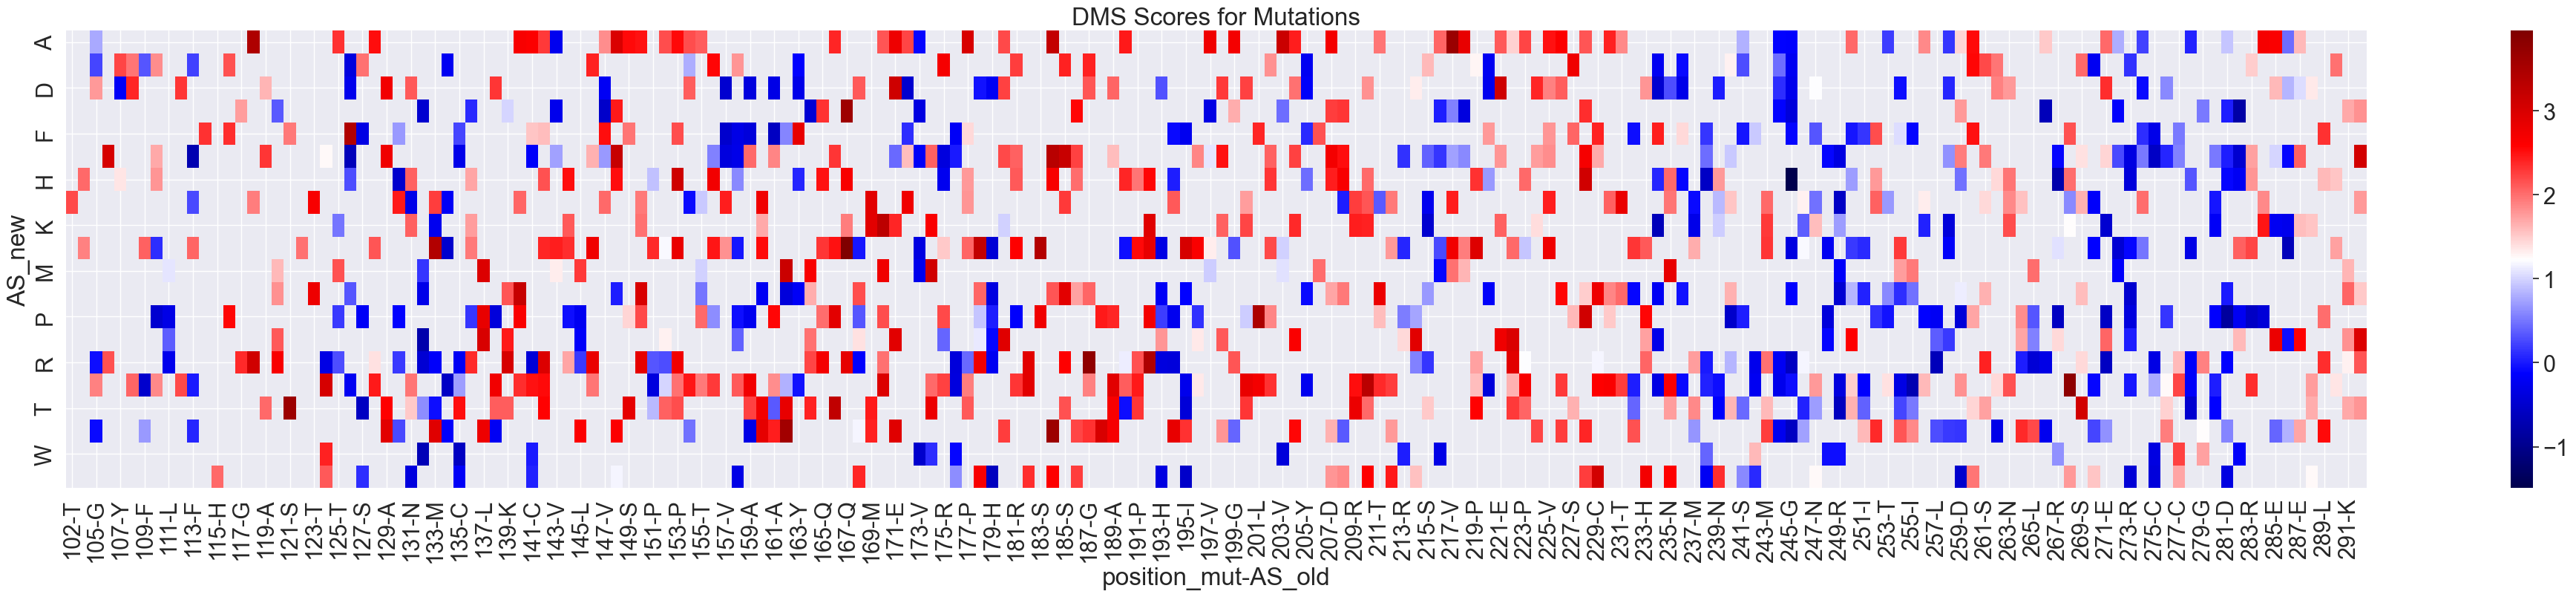

In [15]:
# kotler
fun.hmap(doc.kot_hum_auf)

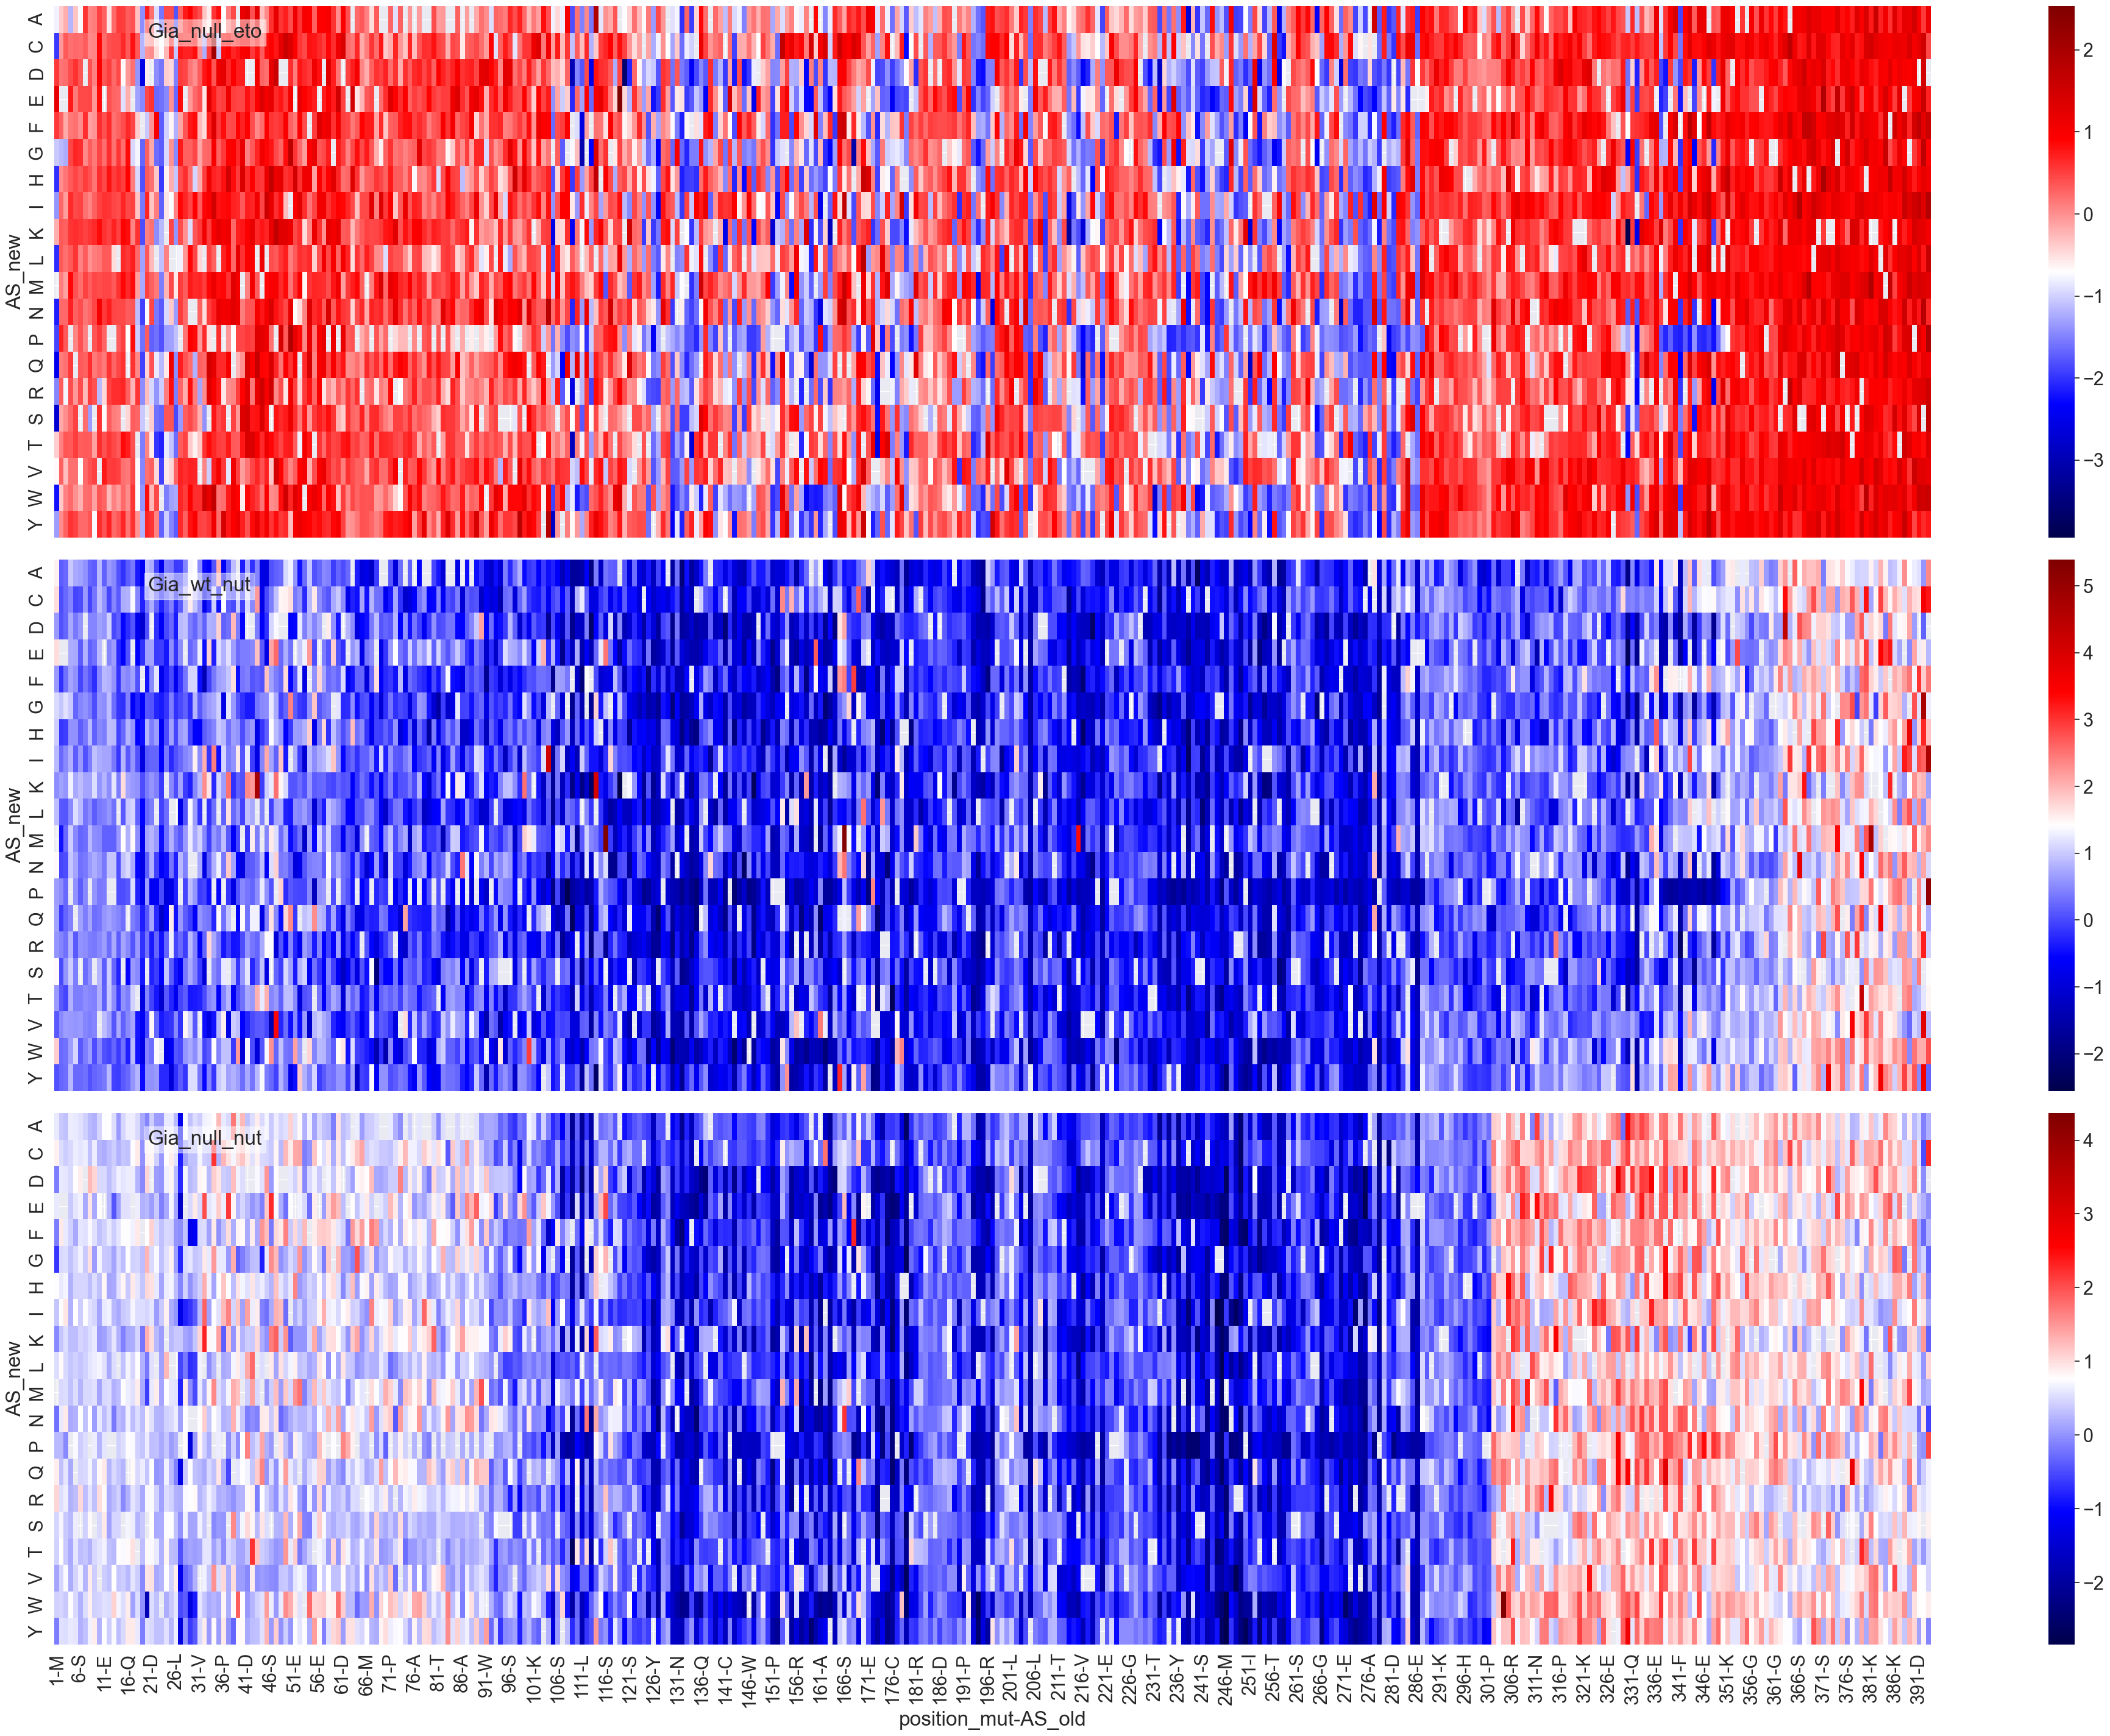

In [16]:
fun.mult_hmap(gia_null_eto, gia_null_nut, gia_wt_nut)

In [17]:
# These heatmaps show different trends:
# What we need to consider is that the Kotler dataset only covers a range of amino acids from x to y. While the "Giacomelli wildtype nutlin" and "Giacomelli null nutlin" datasets exhibit some similarities in terms of trends and values, the same cannot be said when comparing them to the "Giacomelli null etoposide" dataset. This disparity is likely due to the use of different p53 activating agents, namely nutlin-3 and etoposide. One notable observation across all datasets is that amino acids in the range of approximately 100-300 generally display a negative effect caused by mutations. This could indicate a specific region that is evolutionary conserved an perfected. Additionally, the Kotler dataset exhibits a scarcity of values, which should be taken into consideration for future work.

In [18]:
# In addition to visually comparing the datasets, I wanted to investigate whether the datasets share positions in the amino acid sequence where the sum of all DMS scores is the lowest. This would indicate that these specific locations are particularly conserved.

In [19]:
# The 5 lowest values in the "Giacomelli null etoposide" dataset
dc.low_val(gia_null_eto, 5)

                           Sum
position_mut AS_old           
280          R      -33.450339
281          D      -33.446227
278          P      -32.028606
205          Y      -31.805002
275          C      -31.252744


In [20]:
# The 5 highest values in the "Giacomelli null etoposide" dataset
dc.high_val(gia_null_eto, 5)

                           Sum
position_mut AS_old           
392          S       23.640782
388          E       23.569597
393          D       23.458339
391          D       22.853878
374          G       22.718939


In [21]:
# The lowest Values (-> most affected by mutation) are found in:
doc.lowest_vals.head(20)

,Name of the Dataset,Location of lowest DMS_score sum,Sum,Original AA
0,Giacomelli Null Etoposide,280,-33.450339,R
1,Giacomelli NULL Nutlin,205,-27.798457,Y
2,Giacomelli WT Nutlin,245,-41.124490,G
3,Kotler,245,-4.352254,G


In [22]:
#In general, we can also take a look at a flexible number of the most negative locations and take a look at them next to eachother
doc.lowest_vals_gesammelt.head(5)

""


IDEA: Maybe using T-Tests to show differences? In whatever context? -> idea inspired by project proposal from Malte and colleagues

## Data cleanup
#### Preparing the data to enable further anaylses

Z-transfromation and Min Max normalisation of df


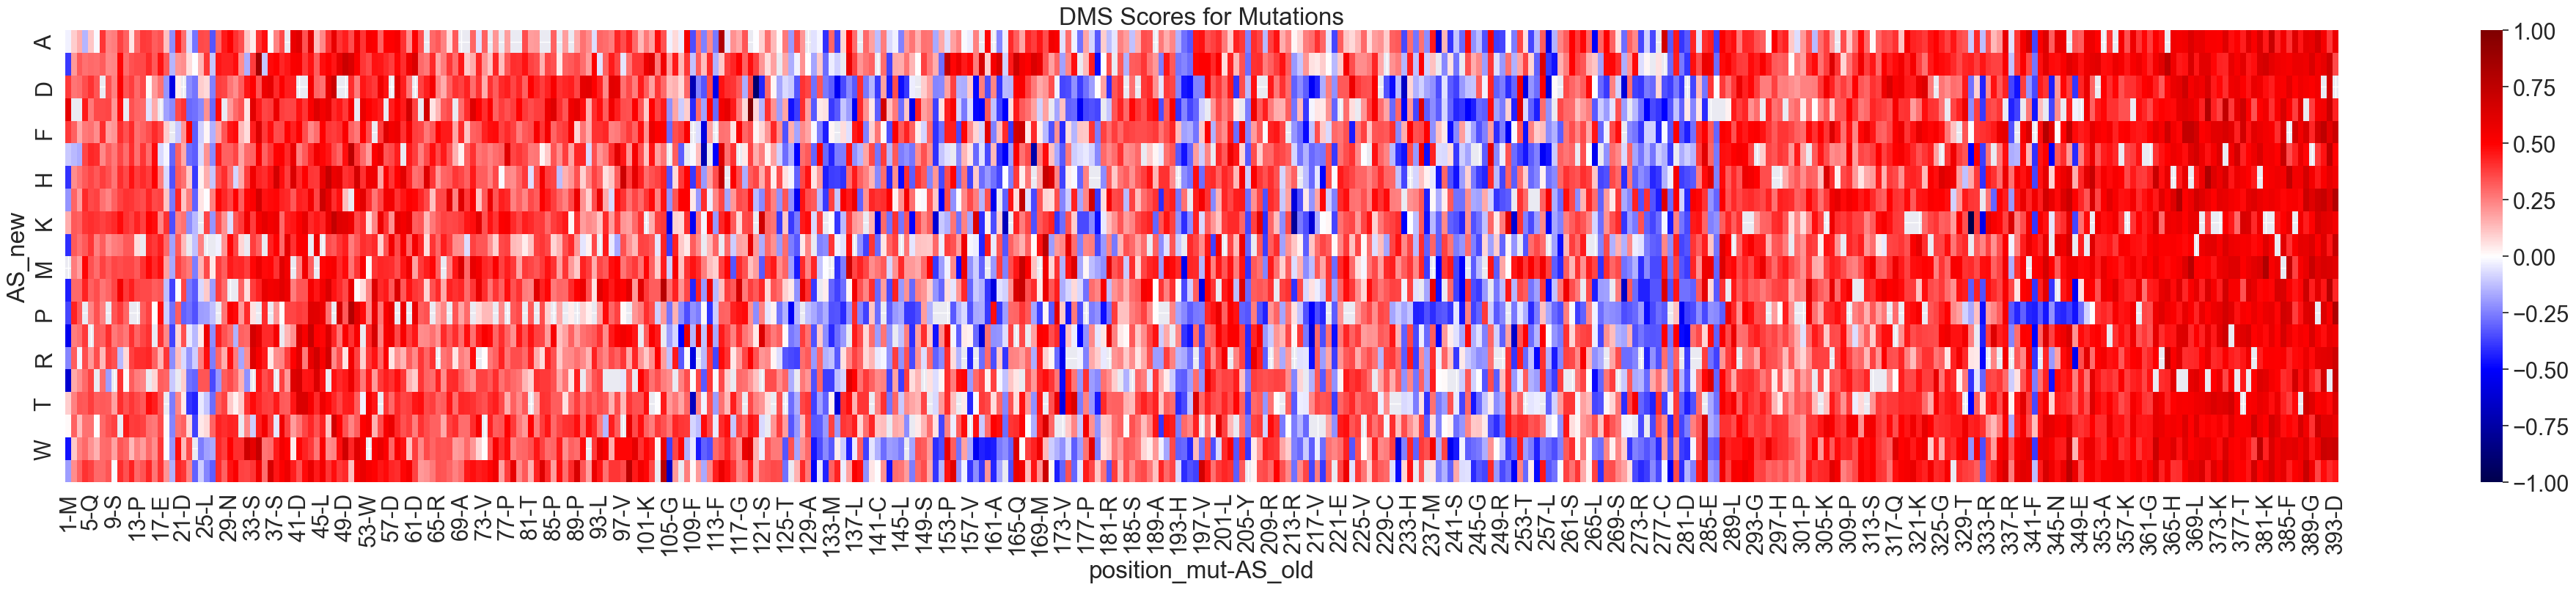

Position of Low and High values of frame


{'min': 6257, 'max': 2252}

In [23]:
# min max Normalisierung
norm_frame = dc.aufteilung_mut_pos(dc.norm(gia_null_eto))
print("Z-transfromation and Min Max normalisation of df")
fun.hmap(norm_frame)
print(f"Position of Low and High values of frame")
dc.min_max_val(norm_frame)

After we finished cleaning our data, we decided to transform the data into a new, more compact format.
In this new data frame the rows resemble the original AA sequence and the rows represent the exchange with a specific AA (e.g. A). The shown values are the DMS scores for the shown substitution. The NAs   shown for the exchanges where the old and new AA are the same, are changed to the value zero. With this transformed data set, further analyses are more easily to perform.

Max: Wir haben probiert Patientendaten zu bekommen, aber wir haben die nicht bekommen

## Data exploration
*Was sind die Ergebnisse, auf die ihr gekommen seid? Also implementierte Funktionen mit einfügen, um dann plotten zu können*

First, we wanted to get a feel for the mean scores for each substitution calculated from the whole length of the p53 protein.

In [24]:
dc.rmv_na(de.mean_substitutions(norm_frame))

AS_new,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
AS_old,,,,,,,,,,,,,,,,,,,,
A,0.000000,0.340947,0.376881,0.358982,0.335680,0.221578,0.250891,0.317547,0.273768,0.220967,0.307664,0.292942,0.181368,0.256354,0.253711,0.304388,0.364976,0.368074,0.286861,0.332373
C,-0.086131,0.000000,-0.248559,-0.219515,0.158800,-0.073344,-0.140790,0.122179,-0.198861,-0.181548,-0.009275,-0.051352,-0.207092,-0.055137,0.059050,0.079754,-0.014635,0.044503,0.008215,0.036375
D,0.321708,0.330375,0.000000,0.384019,0.324023,0.280728,0.369109,0.249072,0.317125,0.273976,0.224402,0.297913,0.200886,0.284410,0.170916,0.325059,0.293815,0.271460,0.330527,0.338131
E,0.353522,0.336021,0.334005,0.000000,0.325770,0.238517,0.374398,0.332433,0.252578,0.312528,0.333914,0.329735,0.115504,0.352908,0.188665,0.302020,0.351699,0.333871,0.284188,0.335100
F,0.004999,0.101043,-0.204574,-0.049255,0.000000,-0.012184,0.063002,0.175149,-0.029470,0.217853,0.232866,-0.027289,-0.039629,0.061709,-0.019351,0.030353,-0.045264,0.097488,0.183231,0.267142
G,0.301196,0.379585,0.284053,0.223599,0.279404,0.000000,0.306521,0.196810,0.242616,0.221750,0.290024,0.321368,0.163262,0.316463,0.195419,0.284876,0.260262,0.286469,0.129454,0.257126
H,0.239014,0.293475,0.199461,0.181253,0.311931,0.127971,0.000000,0.155672,0.129634,0.221671,0.322737,0.357886,0.083293,0.314597,0.230959,0.175897,0.045896,0.212646,0.314705,0.343087
I,-0.184014,0.118796,-0.293719,-0.286043,0.146316,-0.204478,-0.228068,0.000000,-0.223810,0.237746,0.405295,-0.067268,-0.186481,-0.260934,-0.179264,-0.086772,0.089125,0.345619,-0.230402,-0.193905
K,0.392248,0.425960,0.268434,0.266478,0.321344,0.326529,0.384605,0.377365,0.000000,0.397758,0.415306,0.338784,0.318948,0.327565,0.303862,0.370585,0.383838,0.406552,0.337718,0.360055


In [25]:
# Distanzmatrix (DMS-Scores)

dist_chem = de.aa_distance_matrix(aa)

dist_p53 = de.dms_distance_matrix(norm_frame)
mean_subs_p53 = dc.rmv_na(de.mean_substitutions(norm_frame))

With this distance matrix for the whole length of our protein, we wanted to compare these findings with the distances based purely on the chemical properties.

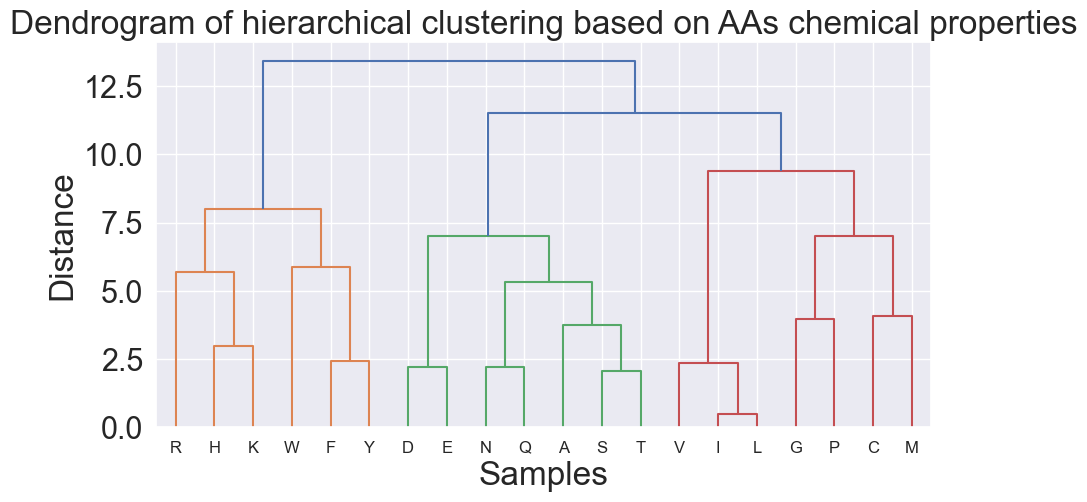

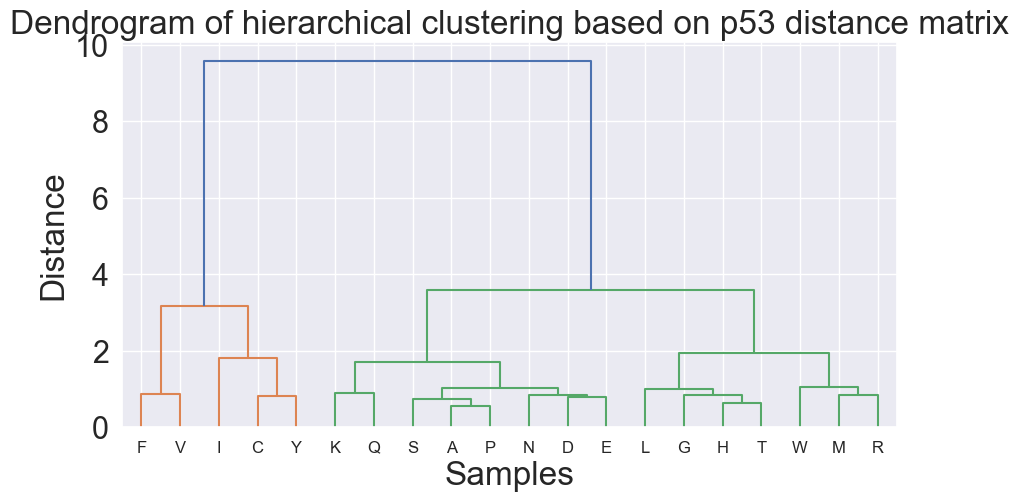

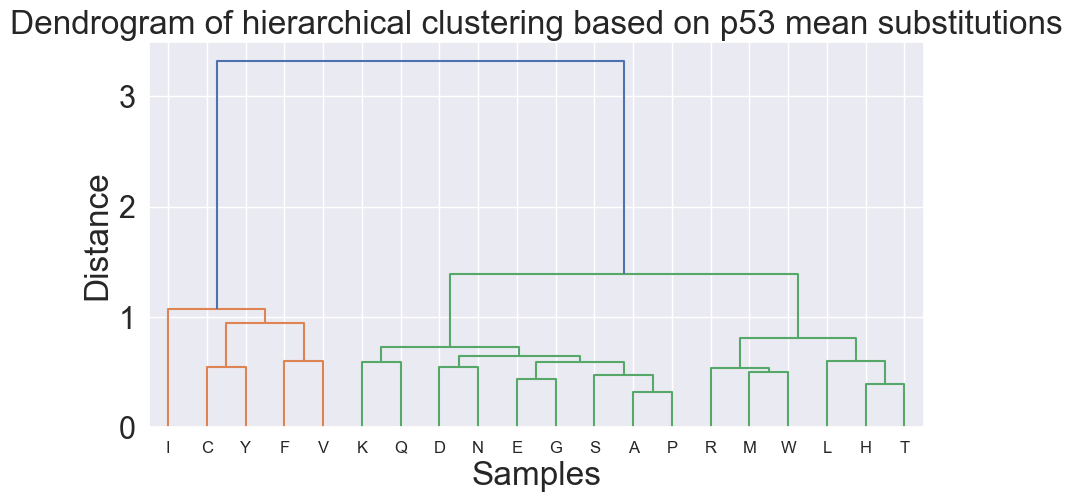

In [26]:
de.plot_hier_clust(dist_chem, title = "AAs chemical properties")

de.plot_hier_clust(dist_p53, title = "p53 distance matrix")
de.plot_hier_clust(mean_subs_p53, title = "p53 mean substitutions")
# hierarchical ward clustering

In [27]:
#determine optimal amount of clusters. Algorithm not optimized, but quite a good estimation
clusters_by_sil_chem = de.determine_clusters_silhouette(dc.clean_aa(aa))

clusters_by_sil_p53 = de.determine_clusters_silhouette(dc.rmv_na(dc.df_transform(norm_frame)))
clusters_by_sil_mean_p53 = de.determine_clusters_silhouette(mean_subs_p53)

print (clusters_by_sil_chem)
print ("---")
print (clusters_by_sil_p53)
print (clusters_by_sil_mean_p53)

4
---
6
2


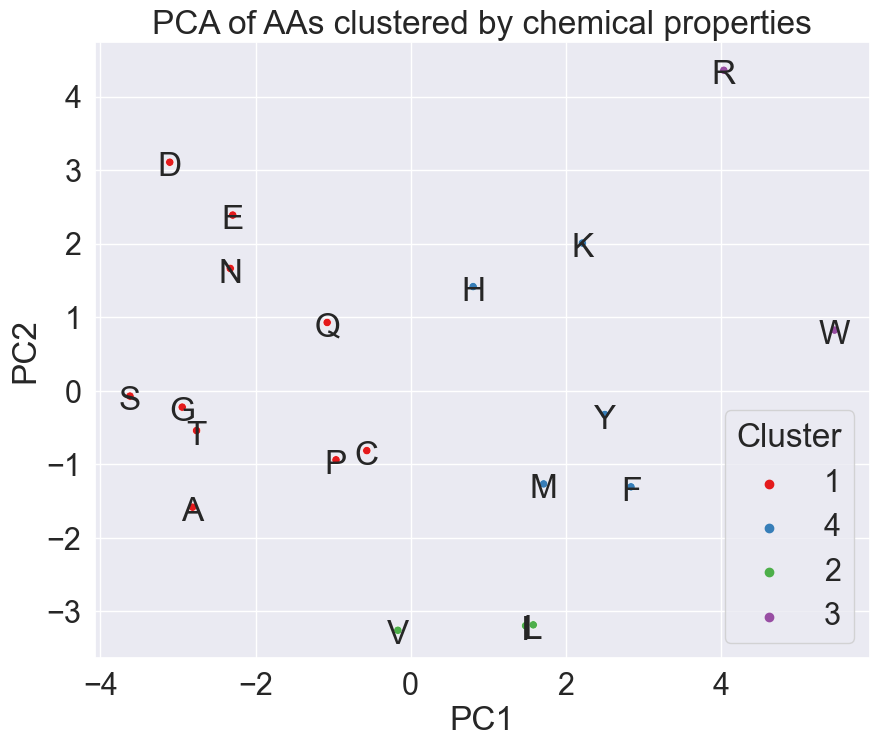

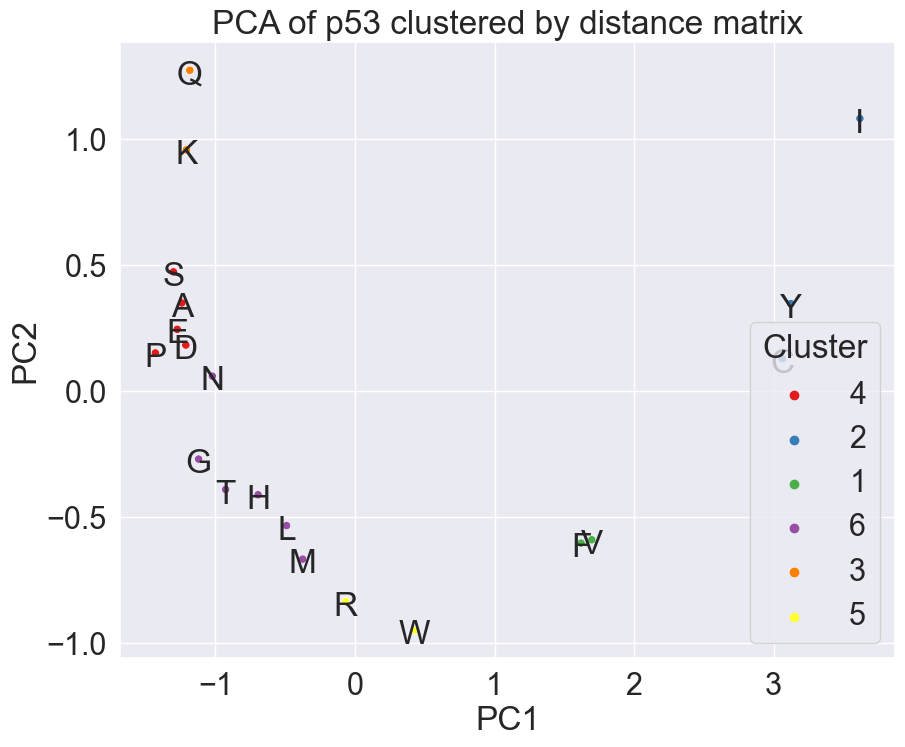

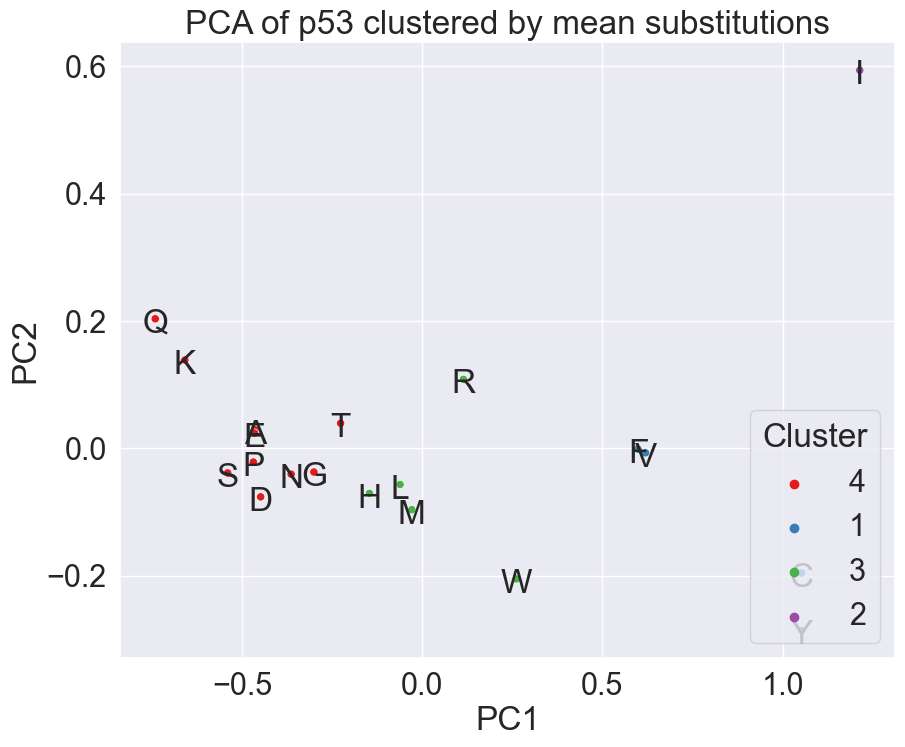

In [28]:
# Plotting, after pca and hierarchical clustering. clusters are defined by the colors shown in the legend.
de.pca_hierarchical_plot(dist_chem, optimal_num_cluster= clusters_by_sil_chem, title = "AAs clustered by chemical properties")

de.pca_hierarchical_plot(dist_p53, optimal_num_cluster=clusters_by_sil_p53, title = "p53 clustered by distance matrix")
de.pca_hierarchical_plot(mean_subs_p53, optimal_num_cluster=4, title = "p53 clustered by mean substitutions")

# I HAVE NO IDEA WHY THESE PLOTS LOOK SO AWFUL IN THIS NOTEBOOK. For better plots look at file "clustering_pca_plotting" in the folder "Data exploration"

## Domain comparison
#### Comparing Clusterings of substitutions in the context of specific protein domains

## Calculating severity scores
#### Matching DMS_scores with the mutation probability (only for single mutations)


In [29]:
#Test for the aminoacid sequence obtained from the DNA sequence online
amino_acids_string = ses.translate_codons_to_string(ses.p53_codons_gia)

print(amino_acids_string)

# BLASTing shows: DNA sequence encodes the AA sequence which is the one the Kotler dataset uses as a reference! Position 72 is Proline, not Arginine.
#However: We want to use the Giacomelli dataset for this analysis, as the Kotler dataset does not contain mutational data for the whole sequence of p53. Therefore, we need to personally edit

MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLSPDDIEQWFTEDPGPDEAPRMPEAAPRVAPAPAAPTPAAPAPAPSWPLSSSVPSQKTYQGSYGFRLGFLHSGTAKSVTCTYSPALNKMFCQLAKTCPVQLWVDSTPPPGTRVRAMAIYKQSQHMTEVVRRCPHHERCSDSDGLAPPQHLIRVEGNLRVEYLDDRNTFRHSVVVPYEPPEVGSDCTTIHYNYMCNSSCMGGMNRRPILTIITLEDSSGNLLGRNSFEVRVCACPGRDRRTEEENLRKKGEPHHELPPGSTKRALPNNTSSSPQPKKKPLDGEYFTLQIRGRERFEMFRELNEALELKDAQAGKEPGGSRAHSSHLKSKKGQSTSRHKKLMFKTEGPDSD


In [49]:
#editing AA 72 from Proline to Arginine by hand: no information available which DNA sequence was used by Giacomelli. Couldn't find information in paper...

#change P codon to R
p53_codons_kotler = [ses.rna_sequence[i:i+3] for i in range(0, len(ses.rna_sequence), 3)]
p53_codons_gia = p53_codons_kotler
p53_codons_gia[71] = "CGC"
dms_scores: pd.DataFrame = dc.norm(dc.df_split(gia_null_eto).replace(np.nan, 0))
severity_score_p53 = ses.dms_smut(p53_codons_gia, gia_null_eto, include_original=True)

<Axes: xlabel='aa_new', ylabel='position_mut'>

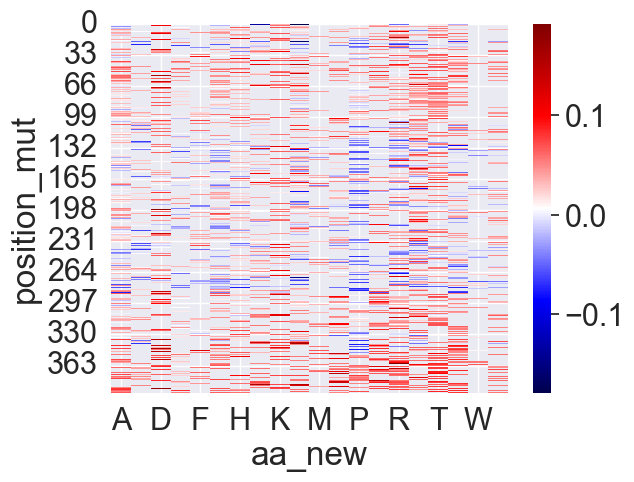

In [37]:
sns.heatmap(severity_score_p53, cmap='seismic')

#hier sieht es so aus, als ob Arginin grundsätzlich die Fitness des Proteins negativ beeinflusst. Könnte man vllt untersuchen, ob das tatsächlich so ist und wie signifikant diese Feststellung ist.

In [32]:
# next -> which probable variations did show an increased fitness score? Is there an AMS with increased DMS score, that
# is not probable by single base Mutation?

#doing analysis on other dataframes

In [50]:
severity_score_p53.compare(dms_scores, keep_equal=True, keep_shape=True, result_names=('smut', 'dms'))

aa_new               A              C                   D                   E   
                  smut       dms smut       dms      smut       dms      smut   
position_mut                                                                    
0                  NaN -0.168502  NaN -0.866931       NaN  0.598737       NaN  \
1            -0.048317  0.010515  NaN  0.004980  0.253714  0.461640 -0.996757   
2             0.073503  0.096724  NaN  0.190582  0.291678  0.478411 -0.996757   
3            -0.491351 -0.336677  NaN  0.124400       NaN  0.558168       NaN   
4                  NaN  0.023911  NaN  0.151089       NaN  0.621464 -0.039062   
...                ...       ...  ...       ...       ...       ...       ...   
388           0.804074  0.681923  NaN  0.676325       NaN  0.761085  0.153351   
389           0.974709  0.816095  NaN  0.513891       NaN  0.804582       NaN   
390           0.730702  0.624231  NaN  0.588468 -0.543753  0.121505  1.000000   
391           0.588050  0.409650  NaN  0.736250       NaN  0.966401       NaN   
392           0.783955  0.666104  NaN  0.246667 -0.543753  0.121505  0.614638   

aa_new                    F            ...         S                   T   
                   dms smut       dms  ...      smut       dms      smut   
position_mut                           ...                                 
0             0.478836  NaN  0.415549  ...       NaN -1.000000 -0.163213  \
1            -0.292508  NaN  0.302028  ...       NaN  0.165773       NaN   
2            -0.292508  NaN  0.099391  ...       NaN  0.254825       NaN   
3             0.289187  NaN  0.238268  ...  0.147925  0.358706  0.255129   
4             0.050641  NaN  0.256079  ...       NaN  0.471829       NaN   
...                ...  ...       ...  ...       ...       ...       ...   
388           0.198170  NaN  0.479534  ...       NaN  0.562197       NaN   
389           0.388492  NaN  0.830233  ...  0.232745  0.447437  0.614922   
390           0.411281  NaN  0.962123  ...       NaN  0.895229       NaN   
391           0.624584  NaN  0.741360  ... -0.566123 -0.077653  0.769911   
392           0.269181  NaN  0.884705  ...       NaN  1.000000       NaN   

aa_new                         V                   W                   Y   
                   dms      smut       dms      smut       dms      smut   
position_mut                                                               
0             0.143952 -0.196336 -0.236035       NaN -0.786962       NaN  \
1             0.355083  0.374945  0.291224       NaN  0.045728       NaN   
2             0.479998  0.011699 -0.029022       NaN  0.241108       NaN   
3             0.470961       NaN  0.248474       NaN  0.316508       NaN   
4             0.559920       NaN  0.241726       NaN  0.204634       NaN   
...                ...       ...       ...       ...       ...       ...   
388           0.914707  0.519041  0.464735  0.813973  0.555301       NaN   
389           0.752204       NaN  1.000000       NaN  0.689286       NaN   
390           0.781827  0.899877  0.837795       NaN  0.913509  0.740287   
391           0.698685       NaN  0.850098       NaN  0.878250       NaN   
392           0.935419  0.851705  0.790607       NaN  0.911673  0.683336   

aa_new                  
                   dms  
position_mut            
0            -0.350732  
1             0.223568  
2             0.346992  
3             0.472928  
4             0.432133  
...                ...  
388           0.694380  
389           0.416601  
390           0.583616  
391           0.494480  
392           0.549047  

[393 rows x 40 columns]